In [1]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson

# import mvts_utils as utils
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [2]:
from utils import (
    adf_test,
    kpss_test,
    grangers_causation_matrix,
    adjust,
    cointegration_test,
    splitter,
    create_plot,
    forecast_accuracy
)


In [3]:
metrics_ = pd.DataFrame()

## Loading the Dataset

In [4]:
ts_prices_eth = pd.read_csv("Data/Time_Series/prices/ethereum.csv",index_col='date',parse_dates=['date'])

In [5]:
# crypto = 'crypto_bitcoin'
crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

In [6]:
for model in ['CRYPTOBERT','VADER']:
    for filetype in ['submission','comment']:
        print(f"{model}_{filetype}_sentiment")
        df = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_{filetype}_sentiment.csv",index_col='posted_on',parse_dates=['posted_on'])
        # print(df.columns)
        for col in df.columns[:3]:
            # ts_prices_btc[f"{model}_{filetype}_{col}_prop"] = df[col]/df['total_posts']
            ts_prices_eth[f"{model}_{filetype}_{col}"] = df[col]
        ts_prices_eth[f"total_{filetype}"] = df['total_posts']

CRYPTOBERT_submission_sentiment
CRYPTOBERT_comment_sentiment
VADER_submission_sentiment
VADER_comment_sentiment


In [7]:
# Remove Neutral Time Series
for c in ts_prices_eth.columns:
    if 'prop' in c.lower() or 'neutral' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_eth.drop(c,axis=1,inplace=True)

Dropping column CRYPTOBERT_submission_Neutral
Dropping column CRYPTOBERT_comment_Neutral
Dropping column VADER_submission_Neutral
Dropping column VADER_comment_Neutral


In [8]:
# Checking for Stationarity
for i in range(0,len(ts_prices_eth.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', ts_prices_eth.columns[i])
    # plot_acf(ts_prices_eth.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_eth.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(ts_prices_eth.iloc[:,i])
    kpss_test(ts_prices_eth.iloc[:,i])
    print("*"*100)

Series: price
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: CRYPTOBERT_submission_Negative
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: CRYPTOBERT_submission_Positive
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: total_submission
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: CRYPTOBERT_comment_

Since some of the time series are not stationary, we'll have to take first difference

In [9]:
df_first_differenced = ts_prices_eth.diff().dropna()
# Checking for Stationarity
for i in range(0,len(df_first_differenced.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', df_first_differenced.columns[i])
    # plot_acf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(df_first_differenced.iloc[:,i])
    kpss_test(df_first_differenced.iloc[:,i])
    print("*"*100)


Series: price
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: CRYPTOBERT_submission_Negative
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: CRYPTOBERT_submission_Positive
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: total_submission
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: CRYPTOBERT_comment_Negative
Augmented Dicky Ful

### CryptoBERT model

In [10]:
df_cryptobert = ts_prices_eth[['price','CRYPTOBERT_submission_Negative','CRYPTOBERT_submission_Positive','total_submission','CRYPTOBERT_comment_Negative','CRYPTOBERT_comment_Positive','total_comment']]
df_differenced = df_first_differenced[['price','CRYPTOBERT_submission_Negative','CRYPTOBERT_submission_Positive','total_submission','CRYPTOBERT_comment_Negative','CRYPTOBERT_comment_Positive','total_comment']]

In [11]:
gc_res = grangers_causation_matrix(df_differenced, variables = df_differenced.columns, maxlag=7)    

In [12]:
def negative_yellow(val):
    color = 'grey' if val < 0.05 else ''
    return 'background-color:' + color  

def negative_bold(val):
    bold = 'bold' if val < 0.05 else ''
    return 'font-weight: %s' % bold

gc_res.style.applymap(negative_yellow).applymap(negative_bold)

,price_x,CRYPTOBERT_submission_Negative_x,CRYPTOBERT_submission_Positive_x,total_submission_x,CRYPTOBERT_comment_Negative_x,CRYPTOBERT_comment_Positive_x,total_comment_x
price_y,1.000000,0.003400,0.081000,0.013600,0.000100,0.015700,0.001300
CRYPTOBERT_submission_Negative_y,0.000000,1.000000,0.000700,0.000000,0.000700,0.000000,0.000000
CRYPTOBERT_submission_Positive_y,0.194500,0.255400,1.000000,0.521000,0.311300,0.245100,0.183800
total_submission_y,0.035500,0.020500,0.226200,1.000000,0.166100,0.001100,0.051800
CRYPTOBERT_comment_Negative_y,0.098600,0.110600,0.013100,0.000600,1.000000,0.000000,0.000200
CRYPTOBERT_comment_Positive_y,0.103600,0.002000,0.064500,0.000600,0.044600,1.000000,0.143000
total_comment_y,0.058500,0.019800,0.033400,0.003000,0.324400,0.033500,1.000000


In [13]:
cointegration_test(df_differenced)

Name                           ::  Test Stat > C(95%)    =>  Signif 
 ----------------------------------------------------------------------
price                          ::  903.44    > 111.7797  =>   True
CRYPTOBERT_submission_Negative ::  690.92    > 83.9383   =>   True
CRYPTOBERT_submission_Positive ::  517.2     > 60.0627   =>   True
total_submission               ::  372.01    > 40.1749   =>   True
CRYPTOBERT_comment_Negative    ::  254.83    > 24.2761   =>   True
CRYPTOBERT_comment_Positive    ::  148.97    > 12.3212   =>   True
total_comment                  ::  55.95     > 4.1296    =>   True


In [14]:
train_df, test_df = splitter(df_differenced)
nobs = len(test_df)

In [15]:
model = VAR(train_df)
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,36.81,36.90,9.691e+15,36.85
1,35.74,36.49*,3.329e+15,36.04
2,35.36,36.75,2.268e+15,35.92*
3,35.24,37.28,2.014e+15*,36.06
4,35.28,37.98,2.121e+15,36.37
5,35.29,38.64,2.136e+15,36.63
6,35.29,39.29,2.156e+15,36.89
7,35.22*,39.87,2.040e+15,37.09
8,35.26,40.57,2.160e+15,37.39
9,35.29,41.24,2.253e+15,37.68


In [16]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Apr, 2024
Time:                     00:53:12
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    39.7846
Nobs:                     284.000    HQIC:                   37.0906
Log likelihood:          -7481.69    FPE:                2.17016e+15
AIC:                      35.2876    Det(Omega_mle):     6.97419e+14
--------------------------------------------------------------------
Results for equation price
                                       coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------
const                                    -8.258182         5.626826           -1.468           0.142
L1.price                                 -0.016598         0.065173           -0.

In [17]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Negative : 2.01
Neutral : 2.04
Positive : 2.02
total_posts : 2.01


In [18]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

7


array([[  0.66,  -1.  ,  -4.  ,  -9.  ,  17.  ,  -9.  ,  44.  ],
       [ -2.07,   1.  ,   5.  ,  10.  ,  -9.  ,   9.  , -14.  ],
       [  6.96,  -1.  ,  -3.  ,  -8.  ,  -4.  ,   0.  ,  -4.  ],
       [-14.43,   0.  ,   3.  ,   7.  ,   6.  ,  -8.  ,  21.  ],
       [-23.09,   0.  ,  -3.  ,   2.  ,  -1.  ,  16.  , -10.  ],
       [ 12.81,   0.  ,  -2.  , -11.  ,  -7.  , -34.  , -73.  ],
       [ -2.43,   2.  ,   2.  ,   3.  ,   6.  ,  11.  ,  44.  ]])

In [19]:
# df = ts_prices_btc[['price','CRYPTOBERT_submission_Negative','CRYPTOBERT_submission_Positive','total_submission','CRYPTOBERT_comment_Negative','CRYPTOBERT_comment_Positive','total_comment']]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)

In [20]:
df_forecast = pd.DataFrame(fc, index=df_cryptobert.index[-nobs:], columns=df_cryptobert.columns)
df_forecast

,price,CRYPTOBERT_submission_Negative,CRYPTOBERT_submission_Positive,total_submission,CRYPTOBERT_comment_Negative,CRYPTOBERT_comment_Positive,total_comment
date,,,,,,,
2022-10-20,-8.073615,-1.946247,-0.924040,-4.670614,-2.845929,4.816286,-11.163094
2022-10-21,14.157657,-0.294423,-0.907134,0.794643,0.576793,-5.115189,-3.135960
2022-10-22,-8.419186,0.855642,2.407227,5.182611,-1.764368,-4.692249,-8.712211
2022-10-23,-29.264984,-0.368306,-0.019483,-2.024192,1.233205,10.502518,21.976027
2022-10-24,31.796213,0.022339,0.216536,4.511795,2.575376,-0.860032,8.474288
2022-10-25,-11.993598,0.506382,-0.946429,-2.310083,-2.335811,-0.961302,-12.430522
2022-10-26,-20.849826,-0.418372,-1.056750,-2.727976,0.264218,-0.008368,-2.147185
2022-10-27,-3.104661,0.161485,0.017620,-2.680917,0.442503,-4.995606,-11.195233
2022-10-28,-14.009759,0.045715,0.571152,1.697490,-0.094898,0.389028,3.200956


In [21]:
row = df_cryptobert.iloc[[0]]
row

,price,CRYPTOBERT_submission_Negative,CRYPTOBERT_submission_Positive,total_submission,CRYPTOBERT_comment_Negative,CRYPTOBERT_comment_Positive,total_comment
date,,,,,,,
2022-01-01,3686.4,0.0,20.0,64.0,16,85,346


In [22]:
# Invert Transformation
df_result = pd.concat([df_differenced.iloc[:291],df_forecast]) 
df_result = pd.concat([row,df_result]).cumsum()

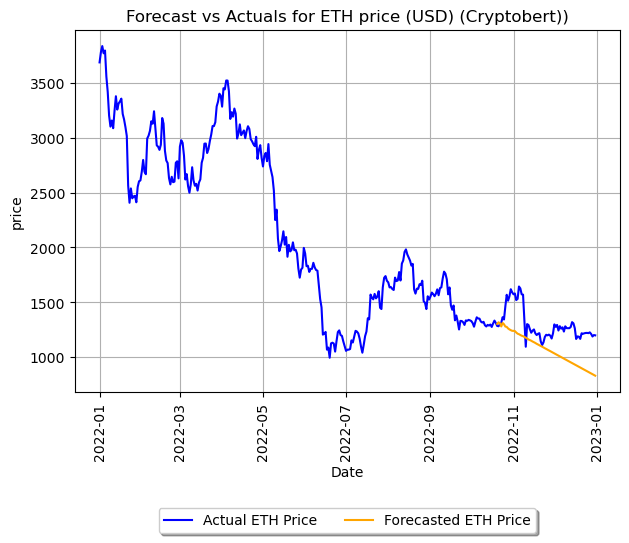

In [23]:
data_predicted = df_result['price'][-nobs:]
data_actual = df_cryptobert['price']
create_plot(data_predicted, data_actual, 'ETH', 'Cryptobert')

In [24]:
print('Forecast Accuracy of: Price')
res = forecast_accuracy(data_predicted.values, data_actual[-nobs:], rowname=['CRYPTOBERT'])
metrics_ = pd.concat([metrics_,res])
metrics_

Forecast Accuracy of: Price


,MAE,MAPE,MSE,RMSE
CRYPTOBERT,228.558975,17.379326,66771.915626,258.402623


### VADER model

In [25]:
df_vader = ts_prices_eth[['price','VADER_submission_Negative','VADER_submission_Positive','total_submission','VADER_comment_Negative','VADER_comment_Positive','total_comment']]
df_differenced = df_first_differenced[['price','VADER_submission_Negative','VADER_submission_Positive','total_submission','VADER_comment_Negative','VADER_comment_Positive','total_comment']]

In [26]:
gc_res = grangers_causation_matrix(df_differenced, variables = df_differenced.columns, maxlag=3)    

In [27]:
def negative_yellow(val):
    color = 'grey' if val < 0.05 else ''
    return 'background-color:' + color  

def negative_bold(val):
    bold = 'bold' if val < 0.05 else ''
    return 'font-weight: %s' % bold

gc_res.style.applymap(negative_yellow).applymap(negative_bold)

,price_x,VADER_submission_Negative_x,VADER_submission_Positive_x,total_submission_x,VADER_comment_Negative_x,VADER_comment_Positive_x,total_comment_x
price_y,1.000000,0.000000,0.009700,0.126200,0.005500,0.095300,0.001300
VADER_submission_Negative_y,0.003800,1.000000,0.084100,0.033200,0.148200,0.040700,0.022000
VADER_submission_Positive_y,0.758900,0.050800,1.000000,0.015300,0.196500,0.505200,0.632000
total_submission_y,0.590200,0.492200,0.607700,1.000000,0.059500,0.288300,0.364400
VADER_comment_Negative_y,0.063800,0.153700,0.445500,0.062400,1.000000,0.433600,0.170800
VADER_comment_Positive_y,0.617900,0.089600,0.005300,0.000700,0.441900,1.000000,0.031400
total_comment_y,0.177800,0.118000,0.037400,0.003000,0.738400,0.388600,1.000000


In [28]:
cointegration_test(df_differenced)

Name                           ::  Test Stat > C(95%)    =>  Signif 
 ----------------------------------------------------------------------
price                          ::  888.01    > 111.7797  =>   True
VADER_submission_Negative      ::  697.01    > 83.9383   =>   True
VADER_submission_Positive      ::  546.93    > 60.0627   =>   True
total_submission               ::  400.38    > 40.1749   =>   True
VADER_comment_Negative         ::  266.88    > 24.2761   =>   True
VADER_comment_Positive         ::  155.19    > 12.3212   =>   True
total_comment                  ::  57.97     > 4.1296    =>   True


In [29]:
train_df, test_df = splitter(df_differenced)
nobs = len(test_df)

In [30]:
model = VAR(train_df)
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,37.42,37.51,1.785e+16,37.46
1,36.15,36.89*,5.012e+15,36.45
2,35.80,37.20,3.539e+15,36.36*
3,35.72*,37.77,3.268e+15*,36.54
4,35.78,38.48,3.484e+15,36.86
5,35.79,39.14,3.528e+15,37.13
6,35.80,39.80,3.593e+15,37.41
7,35.81,40.46,3.676e+15,37.68
8,35.95,41.26,4.296e+15,38.08
9,36.01,41.96,4.618e+15,38.40


In [31]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Apr, 2024
Time:                     00:53:15
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    37.8670
Nobs:                     288.000    HQIC:                   36.6932
Log likelihood:          -7877.38    FPE:                3.94177e+15
AIC:                      35.9083    Det(Omega_mle):     2.35454e+15
--------------------------------------------------------------------
Results for equation price
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               -6.792063         5.423259           -1.252           0.210
L1.price                             0.052755         0.061903            0.852           0.394


In [32]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Negative : 1.97
Neutral : 2.08
Positive : 2.05
total_posts : 2.05


In [33]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[-23.09,   1.  ,   0.  ,   2.  ,  10.  ,  -3.  , -10.  ],
       [ 12.81,   0.  ,  -3.  , -11.  , -12.  , -12.  , -73.  ],
       [ -2.43,   1.  ,  -2.  ,   3.  ,  11.  ,  13.  ,  44.  ]])

In [34]:
# df = ts_prices_btc[['price','CRYPTOBERT_submission_Negative','CRYPTOBERT_submission_Positive','total_submission','CRYPTOBERT_comment_Negative','CRYPTOBERT_comment_Positive','total_comment']]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)

In [35]:
df_forecast = pd.DataFrame(fc, index=df_vader.index[-nobs:], columns=df_vader.columns)
df_forecast

,price,VADER_submission_Negative,VADER_submission_Positive,total_submission,VADER_comment_Negative,VADER_comment_Positive,total_comment
date,,,,,,,
2022-10-20,-34.329477,-1.376868,-0.344999,-2.685074,-5.556949,-5.035410,-1.326427
2022-10-21,8.393866,0.591252,1.862630,3.041795,1.429832,-0.978301,-8.181537
2022-10-22,-4.599773,0.012483,-1.203358,-2.105374,-0.896597,0.634875,0.860958
2022-10-23,-16.419624,-0.130838,0.579331,0.553148,0.804530,-0.794360,-4.639279
2022-10-24,-4.039499,-0.080020,-1.008416,-1.037027,-1.028794,0.516604,3.357800
2022-10-25,-10.739921,0.028483,0.502541,0.262665,0.257650,-1.427002,-4.285769
2022-10-26,-6.348343,-0.027395,-0.291428,-0.437158,-0.262320,0.296189,-0.677353
2022-10-27,-9.892743,-0.048269,-0.060352,-0.200274,0.047018,-0.566765,-1.117861
2022-10-28,-7.977784,-0.030378,-0.204363,-0.379812,-0.396326,-0.141044,-1.331581


In [36]:
row = df_vader.iloc[[0]]
row

,price,VADER_submission_Negative,VADER_submission_Positive,total_submission,VADER_comment_Negative,VADER_comment_Positive,total_comment
date,,,,,,,
2022-01-01,3686.4,5.0,36.0,64.0,28,101,346


In [37]:
# Invert Transformation
df_result = pd.concat([df_differenced.iloc[:291],df_forecast]) 
df_result = pd.concat([row,df_result]).cumsum()

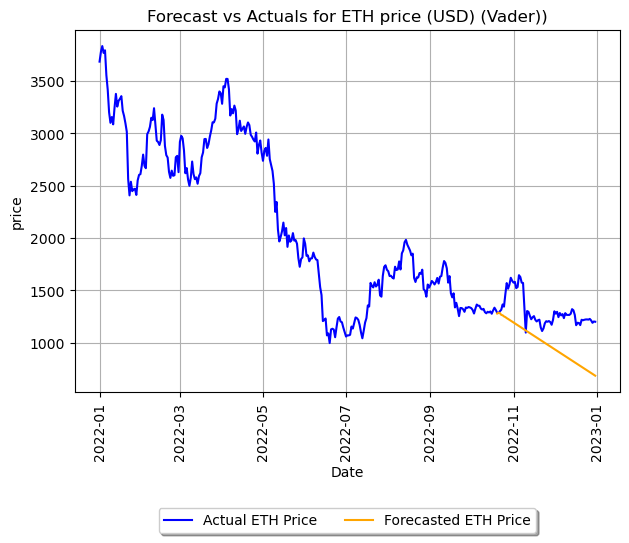

In [38]:
data_predicted = df_result['price'][-nobs:]
data_actual = df_vader['price']
create_plot(data_predicted, data_actual, 'ETH', 'Vader')

In [39]:
print('Forecast Accuracy of: Price')
# accuracy_prod = 
res = forecast_accuracy(data_predicted.values, data_actual[-nobs:],['VADER'])
metrics_ = pd.concat([metrics_, res])
metrics_

Forecast Accuracy of: Price


,MAE,MAPE,MSE,RMSE
CRYPTOBERT,228.558975,17.379326,66771.915626,258.402623
VADER,312.166158,24.017537,118763.079271,344.620196
